In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

目标为构建一个ADL+LSTM的预测体系

上一个脚本中实现了这个功能，但代码写的太烂了，重塑一下

首先定义一个函数，作用是生成一个data_list，里面包含groupby的全部结果，并进行时间升序排列

In [4]:
def group_data(data,target,time='年份'):
    List_=[]
    list_=set(data[target])
    grouped=data.groupby(target)
    for i in tqdm(list_,desc='正在进行 分组降序排列：'):
        try:
            d=grouped.get_group(i)
            d=d.sort_values(by=time, ascending=True)
            List_.append(d)
        except:
            pass
    return List_

------

以下这个函数可以进行对某一个变量的延迟操作，但这满足不了对adl模型的需求

In [5]:
def replace_features_with_lags(df, target_col, lag):
    new_df=df.copy()
    for col in tqdm(df.columns,desc='切割'):
        if col!=target_col:
           new_df[col]=new_df[col].shift(lag)
    new_df=new_df.dropna()
    return new_df

--------

In [6]:
def use_lag_list(data_list,lag_dict): #这个函数使用来处理数据的，初次编写的时候有问题
                                      #use_lag_list2修一下bug
    list_=[]
    for data in tqdm(data_list,desc='正在进行 延迟阶数处理'):
        for i in data.columns:
            lags=lag_dict[i]
            for j in range(lags):
                j=j+1
                data[i+'_'+str(j)+'阶延迟']=data[i].shift(j)
        list_.append(data)
    return list_

In [7]:
def use_lag_list2(x_columns_list,y_columns_list,lag_dict):
    list_=[]
    columns=x_columns_list+y_columns_list
    for i in columns:
        times=lag_dict[i]
        for j in range(times):
            j=j+1
            list_.append(i+'_'+str(j)+'阶延迟')
    return list_

以上内容完成了不同变量延迟阶数的处理，所得到的数据框每一行都是adl模型所需要的样本，我们可以使用最小二乘法进行线性部分的估计

**但是LSTM似乎不需要这样的结构**，下面先进行adl模型的拟合，再设计残差部分

In [8]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [9]:
def plot_Ridge(data):
    for col in data.columns:
        if col!='alpha':
            plt.plot(data['alpha'],data[col],label=col)
            plt.legend()
            plt.grid(True)
        else:
            pass

In [10]:
def ADL_Ridge(data_x,data_y,alpha=None):
    lens=len(data_x.columns)
    if alpha is None:
        List_=[]
        alphas=np.arange(0,10,0.2)
        for alpha in tqdm(alphas,desc='正在进行 岭系数调试：'):
            model=Ridge(alpha=alpha)
            result=model.fit(data_x,data_y)
            list_=[alpha]+list(result.coef_[0])
            List_.append(list_)
        columns=['alpha']+list(data_x.columns)
        Data=pd.DataFrame(np.array(List_),columns=columns)
        #这样写太过于冗杂了，此处需要一个一键绘图的函数
        plot_Ridge(Data)
    else:
        model=Ridge(alpha=alpha)
        result=model.fit(data_x,data_y)
    return result

In [11]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

下面先构建一个简单的LSTM结构，看情况是否需要复杂化这个模型

In [12]:
class LSTM(tf.keras.Model):
    def __init__(self,number_layers,hidden_size):
        super().__init__()
        list_=[]
        for i in range(number_layers-1):
            list_.append(tf.keras.layers.LSTM(units=hidden_size,return_sequences=True))
        list_.append(tf.keras.layers.LSTM(units=hidden_size))
        self.lstm_layers=list_
        self.linear=tf.keras.layers.Dense(1)

    def call(self,x):
        for layer in self.lstm_layers:
            x=layer(x)
        x=self.linear(x)
        return x

这基本上是一个万能的训练模型，应该是比较好用的

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
def train(X,y,MODEL,picture=None,title=None):
    #------分别标准化x和y-----
    #X=data_x.values
    #X_scaler = MinMaxScaler()
    #X=X_scaler.fit_transform(X)
    #
    #y=data_y.values
    #Y_scaler = MinMaxScaler()
    #y=Y_scaler.fit_transform(y)
    
    #-------划分训练集和测试机----
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,shuffle=False)
    batch_size=128
    train_dataset=tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).shuffle(1000)  #相当于pytorch的dataloder
    test_dataset=tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

    #--------进行训练------------
    Model=MODEL(6,64) #这里总还是需要一些参数设计的
    Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse') 
    num_epochs=100
    history=Model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

    #-------是否进行绘图----------
    if picture is None:
        pass
    else:
        try:
            train_preds=Model.predict(X_train)
            test_preds=Model.predict(X_test)
            # 逆缩放预测值和真实值
            train_targets_scaled=Y_scaler.inverse_transform(y_train)
            train_preds_scaled=Y_scaler.inverse_transform(train_preds)
            
            train_targets_scaled=train_targets_scaled[-50:]
            train_preds_scaled=train_preds_scaled[-50:]
            x=range(len(train_preds_scaled))
            # -----绘制预测结果-----
            plt.plot(x,train_targets_scaled, color='black',label='test True')
            plt.plot(x,train_preds_scaled,'--',color='black',label='test Pred')
            plt.title(title)
            plt.legend()
            plt.grid(True)
            plt.savefig(picture,dpi=600)
        except:
            print('绘图错误')
            pass
    #这里有个问题,由于标准化函数在里面，因此还得要输出两个标准化器
    return Model,history

根据上面构件的模型和训练结构，还需要按照城市进行group 然后再进行滑动窗口

In [15]:
def sliding_window(data_x,data_ys,seq_length): #这里要求窗口平滑函数接收一个列表
                                               #因为有可能要处理一一对应的样本
    X=data_x.values
    list_=[]
    for data_y in data_ys:
        y=data_y.values.reshape(-1,1)
        sequences=[]
        targets=[]
        for i in range(len(X) - seq_length):
            sequences.append(X[i:i + seq_length])
            targets.append(y[i + seq_length])
        list_.append(targets)
    return np.array(sequences), list_

In [16]:
def create_sequences(data_list,seq,x_columns_list,y_columns_list): #这个api和我之前定义的那个不一样
    samples_x=[]
    samples_y=[]
    samples_e=[]
    for df in tqdm(data_list,desc='正在处理 窗口平滑分解：'):
        df_x=df[x_columns_list]
        #print(len(df_x.index))
        df_y=df[['残差']]
        df_y2=df[y_columns_list]
        df_ys=[df_y,df_y2]
        try:
            X,y=sliding_window(df_x,df_ys,seq_length=seq)
            #print(y[1])
            samples_x=samples_x+list(X)
            samples_e=samples_e+list(y[0])
            samples_y=samples_y+list(y[1])
        except:
            pass
    #print(len(samples_y))
    return np.array(samples_x),np.array(samples_e),np.array(samples_y)

但是在这个函数里，我们要确保预测后的y_real e e_hat 是一一对应的方便对应画图

因此理论上可以对不同的y计算多次窗口平滑

这里又出现了一个问题，LSTM的训练结构为使用时间长度向量去预测下一时间下的向量
但是我的标准化器之中，需要一起传入列名和之前一样的dataframe
这很麻烦，

也就是说，我需要一个api来专门处理标准化的问题，这个api传入数据 然后输出三个Sclar

In [17]:
def sclar_data(data,x_columns_list,y_columns_list):
    X_scaler=MinMaxScaler()
    E_scaler=MinMaxScaler()
    Y_scaler=MinMaxScaler()
    data_x=data[x_columns_list]
    data_e=data[['残差']]
    data_y=data[y_columns_list]
    data_x=X_scaler.fit_transform(data_x)
    data_e=E_scaler.fit_transform(data_e)
    data_y=Y_scaler.fit_transform(data_y)
    return X_scaler,E_scaler,Y_scaler

In [18]:
class ADL_LSTM():
    def __init__(self,data,x_columns_list,y_columns_list,lag_dict=None):
        #注意lag_list部分
        self.data=data
        self.x_columns_list=x_columns_list
        self.y_columns_list=y_columns_list
        self.data_with_lag=None  #data2中储存的是对data进行删除缺失值、降序排列、增加延迟项的

        self.data_to_lstm=None
        self.lag_dict=lag_dict
        self.x_columns_list_lag=None
        self.L_hat=None
        self.LSTM_model=None
        
        self.history=None
    
    def processing_data(self):
        data=self.data
        data_list=group_data(data,'地区','年份')
       
        if self.lag_dict == None:
            lag_dict={}
            for i in tqdm(data.columns,desc='正在进行 随机延迟生成'):
                lag_dict[i]=3
        else:
            lag_dict=self.lag_dict
        print(len(data_list))
        data_list=use_lag_list(data_list=data_list,lag_dict=lag_dict) #为data添加延迟列
        print(len(data_list))
        data=pd.concat(data_list,axis=0) #注意这里重塑了data，一会有了残差要把残差列放进去
        data=data.dropna(how='any')
        data=data.reset_index(drop=True)
        self.data_with_lag=data
        
        x_columns_list_lag=use_lag_list2(self.x_columns_list,self.y_columns_list,lag_dict)
        self.x_columns_list_lag=x_columns_list_lag

    def ADL_Ridge(self,alpha=None):
        #self.processing_data() #执行一下数据处理函数
        data=self.data_with_lag
        x_columns_list=self.x_columns_list_lag
        y_columns_list=self.y_columns_list
        
        data_x=data[x_columns_list] 
        data_y=data[y_columns_list]
        X_sclar=StandardScaler()
        Y_sclar=StandardScaler()
        data_x_values=X_sclar.fit_transform(data_x)
        data_y_values=Y_sclar.fit_transform(data_y)
        data_x=pd.DataFrame(data_x_values,columns=data_x.columns)
        data_y=pd.DataFrame(data_y_values,columns=data_y.columns)
        
        if alpha==None:
            ADL_Ridge(data_x=data_x,data_y=data_y) #返回一张图，先确定alpha
            #根据确定的alpha计算残差
            result=ADL_Ridge(data_x,data_y,alpha=1)
        else:
            result=ADL_Ridge(data_x,data_y,alpha=alpha)
        
        self.ADL_Riged_Model=result
        y_pred=result.predict(data_x)
        self.L_hat=y_pred
        
        ey=Y_sclar.inverse_transform(data_y.values-y_pred)
        residual=pd.DataFrame(ey,columns=['残差'])
        
        data=pd.concat([residual,data],axis=1)
        D=data[self.x_columns_list+y_columns_list+['残差','地区','年份']]
        self.data_to_lstm=D

    def LSTM(self,seq=3):
        #self.ADL_Ridge()
        data=self.data_to_lstm
        y_columns_list=self.y_columns_list
        x_columns_list=self.x_columns_list+['残差']
        xx,ee,yy=sclar_data(data,x_columns_list,y_columns_list)
        data_sclar=MinMaxScaler()
        #data=data.drop(['地区','年份'],axis=1)
        numeric_cols=data.columns.difference(['地区','年份'])
        data[numeric_cols]=data_sclar.fit_transform(data[numeric_cols])
        #data=data_sclar.fit_transform(data)
        data_list=group_data(data,'年份')
        
        X,e,y=create_sequences(data_list,seq,x_columns_list,y_columns_list)  #注意这里的X,e,y都已经是标准化后的
        self.LSTM_samples=[X,e,y]
        print('正在进行 LSTM训练 ...')
        Model,history=train(X,e,LSTM)

        self.LSTM_model=Model
        self.history=history
        self.X_Scaler=xx
        self.E_Scaler=ee
        self.Y_Scaler=yy
        self.e_pred=Model.predict(X)
        self.y_real=y
        self.e_real=e
        
    def fit(self,alpha=None,seq=3):
        self.processing_data()
        self.ADL_Ridge(alpha=alpha)
        self.LSTM(seq=seq)
        
    def fit_withpicture(self,seq=3,alpha=None):
        self.processing_data()
        self.ADL_Ridge(alpha=alpha)
        self.LSTM(seq=seq)
        yy=self.Y_Scaler
        y_real=yy.inverse_transform(self.y_real)
        ee=self.E_Scaler
        e_pred=ee.inverse_transform(self.e_pred)
        e_real=ee.inverse_transform(self.e_real)
        print(e_real)
        
        
                


正在进行 随机延迟生成: 100%|█████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 6994.67it/s]


250


正在进行 延迟阶数处理: 100%|█████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.85it/s]


250


正在进行 岭系数调试：: 100%|███████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.75it/s]


正在进行 LSTM训练 ...


正在处理 窗口平滑分解：: 100%|████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 142.79it/s]


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
[[ 0.44354388]
 [-0.18697066]
 [ 0.14468691]
 ...
 [ 0.52591956]
 [ 0.14892929]
 [ 0.18316116]]


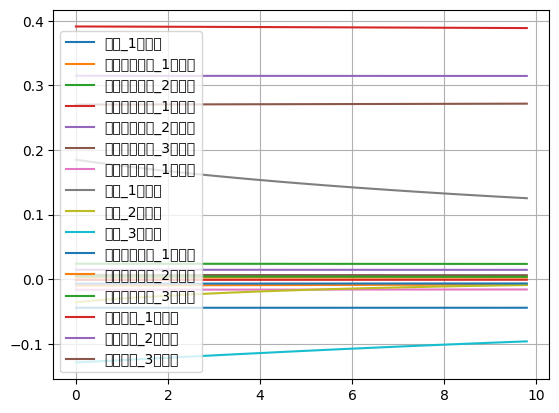

In [19]:
if __name__=='__main__':
    data=pd.read_excel('总模型数据.xlsx')
    x_columns_list=['人口','科技水平支持','教育水平支持','对外开放水平','经济','产业结构升级']
    y_columns_list=['数字经济']
    M=ADL_LSTM(data=data,x_columns_list=x_columns_list,y_columns_list=y_columns_list)
    M.fit_withpicture()